<a href="https://colab.research.google.com/github/shakasom/GDS/blob/master/Part2_Geoprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this tutorial part, we will learn how to perform geoprocesing tasks in Python by performing several spatial data processing and analysis techniques with Geopandas.

### Learning Objectives:
1. Understand GeodataFrames and Geoseries
2. Perform Table join and Spatial Join
3. Carry out buffer and overlay analysis

In [0]:
%%time 

# Important library for many geopython libraries
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes 
# Install Folium for Geographic data visualization
!pip install folium
# Install plotlyExpress
!pip install plotly_express

## 1. GeodataFrame & Geoseries

You have already seen how to load geographic data with Geopandas. Once you load the data, what we get is a table with geographic geometries. The geographic geometries allow us to perform spatial operations in addition to the typical tabular data analysis in pandas or simple excel.

If you have more than one column, it is called a Geodataframe. If it contains only one single column (1 Dimensional), then it is called Geoseries. This is similar to Pandas Dataframe and Series if you are familiar. Let us see how they are different.

In [0]:

import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import matplotlib
import matplotlib.pyplot as plt 
import folium
import plotly_express as px

In [26]:
!git clone --recursive https://github.com/shakasom/GDS.git

fatal: destination path 'GDS' already exists and is not an empty directory.


In [27]:
# Let us see what we have inside GDS Folder
!ls GDS/dataset/

1-introData.zip


In [28]:
# We have zipped data so let us unzip it
!unzip GDS/dataset/1-introData.zip

Archive:  GDS/dataset/1-introData.zip
replace 1-introData/cities.geojson? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: 1-introData/cities.geojson  
  inflating: 1-introData/countries.gpkg  
  inflating: 1-introData/rivers.gpkg  


In [0]:
# Read the data

# 1. Read Countries --> Geopackage Format
file = '1-introData/countries.gpkg'
countries = gpd.read_file(file)

# Cities: Point data
cities = gpd.read_file('1-introData/cities.geojson')

In [30]:
countries.head()

,NAME,POP_EST,POP_RANK,GDP_MD_EST,POP_YEAR,LASTCENSUS,GDP_YEAR,ECONOMY,INCOME_GRP,CONTINENT,geometry
0,Indonesia,260580739,17,3028000.0,2017,2010,2016,4. Emerging region: MIKT,4. Lower middle income,Asia,(POLYGON ((117.7036079039552 4.163414542001791...
1,Malaysia,31381992,15,863000.0,2017,2010,2016,6. Developing region,3. Upper middle income,Asia,(POLYGON ((117.7036079039552 4.163414542001791...
2,Chile,17789267,14,436100.0,2017,2002,2016,5. Emerging region: G20,3. Upper middle income,South America,(POLYGON ((-69.51008875199994 -17.506588197999...
3,Bolivia,11138234,14,78350.0,2017,2001,2016,5. Emerging region: G20,4. Lower middle income,South America,(POLYGON ((-69.51008875199994 -17.506588197999...
4,Peru,31036656,15,410400.0,2017,2007,2016,5. Emerging region: G20,3. Upper middle income,South America,(POLYGON ((-69.51008875199994 -17.506588197999...


In [31]:
# Rows and columns of the countries data
countries.shape

(253, 11)

### DataFrame vs. GeoDataFrame.


A GeoDataFrame is a tabular data structure that contains a GeoSeries.

The most important property of a GeoDataFrame is that it always has one GeoSeries column that holds a special status. This GeoSeries is referred to as the GeoDataFrame’s “geometry”. When a spatial method is applied to a GeoDataFrame (or a spatial attribute like area is called), this commands will always act on the “geometry” column.

If you have more than one column, you have either a dataFrame or GeodataFrame. If One of the columns is a Geoemetry Column, then it is called a **GeoeDataFrame**. Otherwise, it is a **DataFrame** if any of the columns is not a geometry column. Similarly, One column means you have either a Series or Geoseries data type. If the only column is the Geometry column, then it is called Geoseries. Let us see an example of each data type

In [32]:
# DataFrame
dataFrame = countries[['NAME', 'POP_EST']]

dataFrame.head()
type(dataFrame)

pandas.core.frame.DataFrame

In [33]:
# GeoDataFrame
geoDataFrame = countries[['geometry', 'NAME']]
geoDataFrame.head()
type(geoDataFrame)

geopandas.geodataframe.GeoDataFrame

In [34]:
# Series
series = countries['NAME']
series[:5]
type(series)

pandas.core.series.Series

In [35]:
# GeoSeries
geoSeries = countries['geometry']
geoSeries[:5]
type(geoSeries)

geopandas.geoseries.GeoSeries

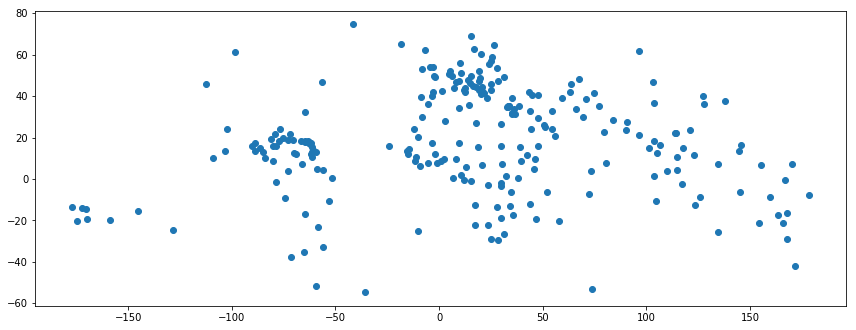

In [60]:
fig, ax = plt.subplots(figsize=(12,12))
geoDataFrame.centroid.plot(ax=ax)
plt.tight_layout()
plt.savefig('centroid.png')
plt.show()

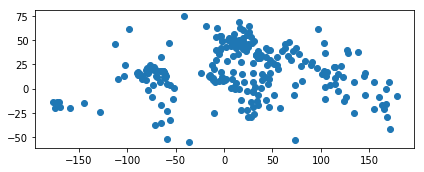

In [65]:
geoDataFrame.centroid.plot();
plt.tight_layout()
plt.savefig('centriod_plot.png')



In [37]:
geoSeries.area[:5]

0    153.078608
1     26.703172
2     76.761813
3     92.203587
4    106.417089
dtype: float64

## 2. Table Join vs. Spatial join

Table joins is classical query operation where we have two separate tables, for example, sharing one column. In that case, you can perform a table join where the two tables are joined using the shared column. On the other hand, spatial join relates to geographic operations, for example, joining by location each city and its country. We will see both examples below.

In [38]:
# To simplify let us seperate country table into two tables. 

# This table holds the geometry and country names
country_shapes = countries[['geometry', 'NAME']]
country_shapes.head()


,geometry,NAME
0,(POLYGON ((117.7036079039552 4.163414542001791...,Indonesia
1,(POLYGON ((117.7036079039552 4.163414542001791...,Malaysia
2,(POLYGON ((-69.51008875199994 -17.506588197999...,Chile
3,(POLYGON ((-69.51008875199994 -17.506588197999...,Bolivia
4,(POLYGON ((-69.51008875199994 -17.506588197999...,Peru


In [39]:
# This table holds Country names and Population estimate
country_names = countries[['NAME', 'POP_EST']]
country_names.head()
# Notice that is not geodataframe as it does not have any geometry.
# Check its type

,NAME,POP_EST
0,Indonesia,260580739
1,Malaysia,31381992
2,Chile,17789267
3,Bolivia,11138234
4,Peru,31036656


We can join/merge the two tables based on their shared column NAME. This is pure pandas operation and does not entail any geographic operations.

In [41]:
# Merge country_shapes to country names on ISO_A3 Column. 
country_merged = country_shapes.merge(country_names, on='NAME', how='left')
country_merged.head()

,geometry,NAME,POP_EST
0,(POLYGON ((117.7036079039552 4.163414542001791...,Indonesia,260580739
1,(POLYGON ((117.7036079039552 4.163414542001791...,Malaysia,31381992
2,(POLYGON ((-69.51008875199994 -17.506588197999...,Chile,17789267
3,(POLYGON ((-69.51008875199994 -17.506588197999...,Bolivia,11138234
4,(POLYGON ((-69.51008875199994 -17.506588197999...,Peru,31036656


#### Spatial Join

In [0]:
# This gdf holds the geometry and country names
country_names = countries[['geometry', 'NAME']]

# This gdf holds the geometry and city names
cities_names = cities[['name', 'geometry']]


We will perform an example of a spatial join. We want to join the two tables based on their locations. For example, which country does contain which city or which city is within which country. We will use Geopandas function.

```
sjoin()

```

to do the spatial join.

In [47]:
# Merge city names and country names
cities_with_country = gpd.sjoin(cities_names, country_names, how="inner", op='within')
cities_with_country.sample(5)


,name,geometry,index_right,NAME
3869,Bitam,POINT (11.48337113307133 2.083657042342452),146,Gabon
5354,Latur,POINT (76.56999263398285 18.40041302385299),8,India
3487,Latacunga,POINT (-78.60996687998431 -0.929569886380477),136,Ecuador
5215,Wanzhou,POINT (108.40003942773 30.81999086407211),9,China
6467,Matamoros,POINT (-97.50000248390103 25.87998231913042),155,Mexico


Each city is matched with its corresponding country based on the location. We have used op=within which takes city points that are within a countries polygon. Here we could also use intersect. Also, we could use op=contain and find out which countries contain the city points.

## 3. Buffer Analysis
Buffer analysis is an important geoprocessing task. It is used widely in many domains to get a distance around a point. In this example, we will first get a city in Sweden and then do a buffer around it. One tricky thing here is you need to know which CRS/projection you are using to get the correct output you want. If your data is not projected into projection where meters are used, then the output will not be in meters. This is a classical error in the world of Geodata. I have used this resource to find out which crs sweden has in meters: http://spatialreference.org/ref/epsg/sweref99-tm/

In [48]:
# Find out stockholm from the cities
stocholm = cities[cities.name == 'Stockholm']
stocholm = stocholm.to_crs({'init': 'epsg:3006'})
stocholm

,name,worldcity,megacity,latitude,longitude,pop_max,pop_min,pop_other,geometry
7287,Stockholm,1.0,1,59.35076,18.097335,1264000,1253309,0,POINT (675974.0101142136 6583418.11625758)


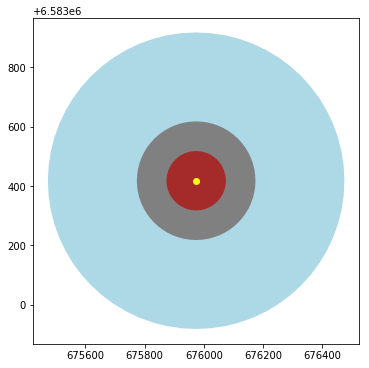

In [66]:
# Let us create a buffer of 500, 200, 100 meters and plot them
stocholm_100 = stocholm.buffer(100)
stocholm_200 = stocholm.buffer(200)
stocholm_500 = stocholm.buffer(500)
fig, ax = plt.subplots(figsize=(8,6))

stocholm_500.plot(ax=ax, color='lightblue')
stocholm_200.plot(ax=ax, color='gray')
stocholm_100.plot(ax=ax, color='brown')
stocholm.plot(ax=ax, color='Yellow');
plt.savefig('buffer.png')

## 4. Overlay
We sometimes need to create new features out of different data types like Points, Lines and Polygons. Set operations or Overlays play an important role here. We will be using the same dataset but instead of reading it from our desk folders we can use built-in dataset reading mechanism in Geopandas. This example comes from Geopandas documentation.

In [51]:
# Let us see what data is available in Geopandas
gpd.datasets.available

['naturalearth_lowres', 'naturalearth_cities', 'nybb']

In [0]:
# Read from the geopandas dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
capitals = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))

#capitals.head()
#capitals.plot()

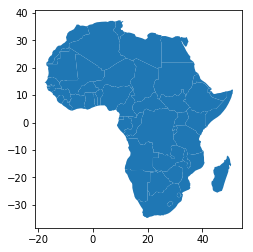

In [67]:
# Select Africa
africa = world[world['continent'] == "Africa"]
africa = africa[['geometry', 'name']]

#africa.shape
africa.plot();
plt.savefig('africa.png')

In [0]:
# Project to crs that uses meters as distance measure
africa = africa.to_crs('+init=epsg:3395')
capitals = capitals.to_crs('+init=epsg:3395')

To illustrate the overlay function, consider the following case in which one wishes to identify the “core” portion of each country – defined as areas within 500km of a capital – using a GeoDataFrame of Africa and a GeoDataFrame of capitals.

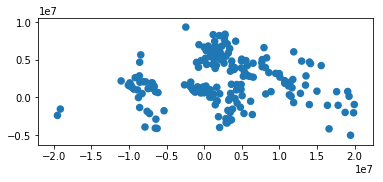

In [56]:
# make 500km buffer
capitals['geometry']= capitals.buffer(500000)
capitals.plot();

To select only the portion of countries within 500km of a capital, we specify the how option to be “intersect”, which creates a new set of polygons where these two layers overlap:

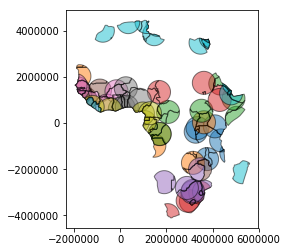

In [57]:
africa_cores = gpd.overlay(africa, capitals, how='intersection')
africa_cores.plot(alpha=0.5, edgecolor='k', cmap='tab10');

Changing the “how” option allows for different types of overlay operations. For example, if we were interested in the portions of countries far from capitals (the peripheries), we would compute the difference between the two.

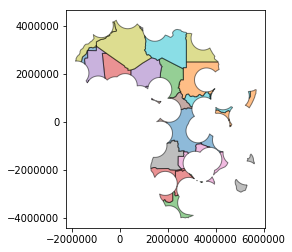

In [58]:
africa_peripheries = gpd.overlay(africa, capitals, how='difference')

africa_peripheries.plot(alpha=0.5, edgecolor='k', cmap='tab10');

# End